### Constants

In [1]:
DEPARTURE = 'LEMD'
DESTINATIONS = [
  'LEAS',
  'LEBB',
  'LEBL',
  'LECO',
  'LEGR',
  'LEJR'
]

FLIGHTS_PATH = 'data/flights'
FLIGHTS_POINTS_PATH = 'data/flight_points'

METHOD = 'davies_bouldin'
GRAPHS_PATH = f'results/graphs/trajectories/{METHOD}'

In [2]:
from src.pipeline import build_pipeline

data_pipeline = build_pipeline(flights_path = FLIGHTS_PATH, 
                               flights_points_path = FLIGHTS_POINTS_PATH, 
                               departure = DEPARTURE, 
                               destinations = DESTINATIONS)

trajectories_result, sspd_calculator, erp_calculator = data_pipeline.transform(None)

trajectories = trajectories_result['trajectories']
sspd_distances = sspd_calculator['sspd_distances']
erp_distances = erp_calculator['erp_distances']

## SSPD distances

### DBSCAN

In order to determine the best value of eps for your dataset, use the K-Nearest Neighbours approach as explained in these two papers: [Sander et al. 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.63.1629&rep=rep1&type=pdf) and [Schubert et al. 2017](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) (both papers from the original DBSCAN authors).

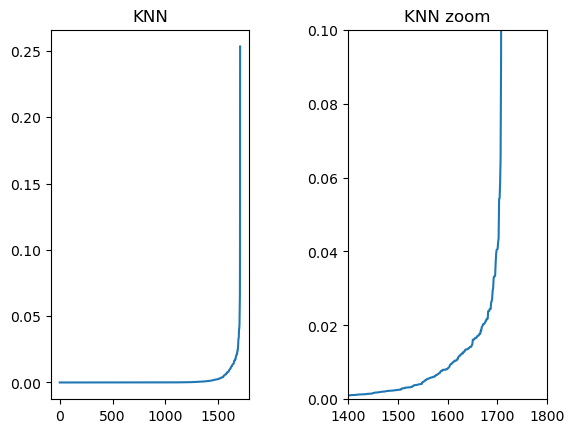

In [3]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(sspd_distances)
distances, indices = neighbors_fit.kneighbors(sspd_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([1400, 1800, 0, 0.1])

plt.savefig(f'{GRAPHS_PATH}/elbow_sspd.png', dpi=600, bbox_inches='tight')

In [4]:
import pandas as pd
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(sspd_distances, params = {
  "eps": np.arange(0.01, 0.1, 0.005),
  "min_samples": np.arange(3, 16)
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                             params  clusters  outliers   
0    {'eps': 0.09499999999999999, 'min_samples': 3}         7         5  \
1    {'eps': 0.09499999999999999, 'min_samples': 4}         7         5   
2    {'eps': 0.09499999999999999, 'min_samples': 5}         7         5   
3    {'eps': 0.09499999999999999, 'min_samples': 6}         7         5   
4    {'eps': 0.09499999999999999, 'min_samples': 7}         7         5   
5    {'eps': 0.09499999999999999, 'min_samples': 8}         7         5   
6    {'eps': 0.09499999999999999, 'min_samples': 9}         7         5   
7   {'eps': 0.09499999999999999, 'min_samples': 10}         7         5   
8   {'eps': 0.09499999999999999, 'min_samples': 11}         7         5   
9   {'eps': 0.09499999999999999, 'min_samples': 12}         7         5   
10  {'eps': 0.09499999999999999, 'min_samples': 13}         7         5   
11  {'eps': 0.09499999999999999, 'min_samples': 14}         7         5   
12  {'eps': 0.09499999999

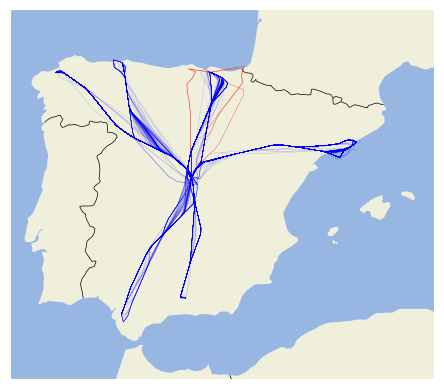

In [5]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

# Run the grid search
params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(sspd_distances)
labels = clusterer.labels_

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_sspd_dbscan.png')

### HDBSCAN

In [6]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(sspd_distances, params = { 
    "min_samples": np.arange(1, 16),
    "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                         params  clusters  outliers     noise   
0    {'min_samples': 1, 'min_cluster_size': 80}        10        57  3.333333  \
1    {'min_samples': 2, 'min_cluster_size': 80}        10        57  3.333333   
2    {'min_samples': 3, 'min_cluster_size': 80}        10        57  3.333333   
3    {'min_samples': 4, 'min_cluster_size': 80}        10        57  3.333333   
4    {'min_samples': 5, 'min_cluster_size': 80}        10        57  3.333333   
5    {'min_samples': 6, 'min_cluster_size': 80}        10        57  3.333333   
6    {'min_samples': 7, 'min_cluster_size': 80}        10        57  3.333333   
7    {'min_samples': 8, 'min_cluster_size': 80}        10        57  3.333333   
8    {'min_samples': 9, 'min_cluster_size': 80}        10        57  3.333333   
9   {'min_samples': 10, 'min_cluster_size': 80}        10        57  3.333333   
10  {'min_samples': 11, 'min_cluster_size': 80}        10        57  3.333333   
11  {'min_samples': 12, 'min

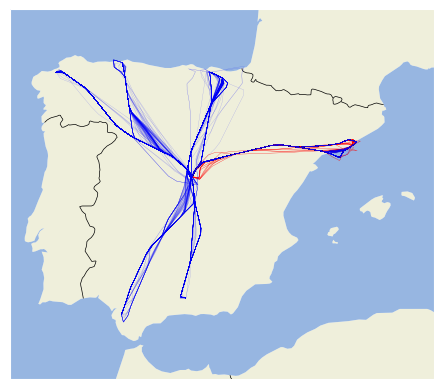

In [7]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(sspd_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_sspd_hdbscan.png')

## ERP Distances

### DBSCAN

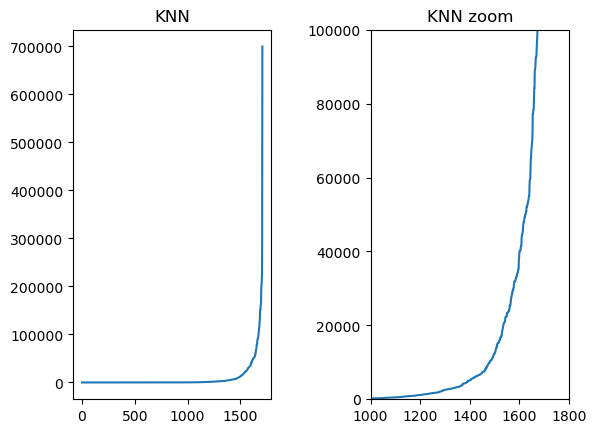

In [8]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(erp_distances)
distances, indices = neighbors_fit.kneighbors(erp_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([1000, 1800, 0, 100000])

plt.savefig(f'{GRAPHS_PATH}/elbow_erp.png', dpi=600, bbox_inches='tight')

In [9]:
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(erp_distances, params = {
  "eps": np.arange(50000, 220000, 5000),
  "min_samples": np.arange(1, 5)
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                               params  clusters  outliers  noise   
0    {'eps': 50000, 'min_samples': 1}       136         0    0.0  \
1    {'eps': 90000, 'min_samples': 1}        83         0    0.0   
2    {'eps': 75000, 'min_samples': 1}        97         0    0.0   
3    {'eps': 80000, 'min_samples': 1}        91         0    0.0   
4    {'eps': 85000, 'min_samples': 1}        87         0    0.0   
5    {'eps': 55000, 'min_samples': 1}       120         0    0.0   
6    {'eps': 65000, 'min_samples': 1}       109         0    0.0   
7    {'eps': 70000, 'min_samples': 1}       101         0    0.0   
8    {'eps': 60000, 'min_samples': 1}       111         0    0.0   
9    {'eps': 95000, 'min_samples': 1}        76         0    0.0   
10  {'eps': 120000, 'min_samples': 1}        56         0    0.0   
11  {'eps': 115000, 'min_samples': 1}        60         0    0.0   
12  {'eps': 110000, 'min_samples': 1}        62         0    0.0   
13  {'eps': 105000, 'min_samples': 1}        66 

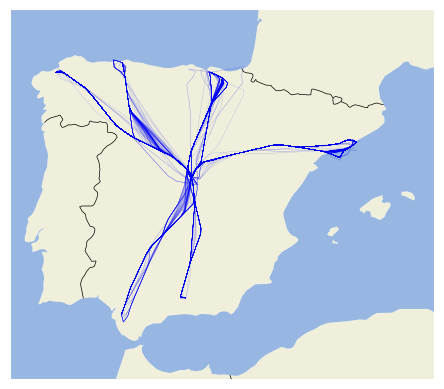

In [10]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_erp_dbscan.png')

### HDBSCAN

In [11]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(erp_distances, params = {
  "min_samples": np.arange(1, 16),
  "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                         params  clusters  outliers     noise   
0    {'min_samples': 1, 'min_cluster_size': 80}        10        47  2.748538  \
1    {'min_samples': 2, 'min_cluster_size': 60}        10        49  2.865497   
2    {'min_samples': 2, 'min_cluster_size': 80}        10        49  2.865497   
3    {'min_samples': 3, 'min_cluster_size': 60}        10        49  2.865497   
4    {'min_samples': 3, 'min_cluster_size': 80}        10        49  2.865497   
5    {'min_samples': 4, 'min_cluster_size': 60}        10        51  2.982456   
6    {'min_samples': 4, 'min_cluster_size': 80}        10        51  2.982456   
7    {'min_samples': 5, 'min_cluster_size': 60}        10        51  2.982456   
8    {'min_samples': 5, 'min_cluster_size': 80}        10        51  2.982456   
9   {'min_samples': 10, 'min_cluster_size': 80}        10        55  3.216374   
10  {'min_samples': 11, 'min_cluster_size': 60}        10        54  3.157895   
11  {'min_samples': 11, 'min

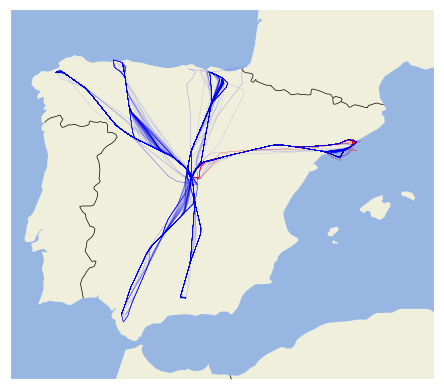

In [12]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(erp_distances)


show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_erp_hdbscan.png')